# The best classifier 
It was my final project in course named 'Machine Learning with Python' - 30.03.2021, Hang Nguyen

Task: build a classifier to predict whether a loan case will be paid off or not.

Dataset includes 2 parts: loan_train.csv (for trainning the models) and loan_test.csv (for testing the models)

Use the following algorithms to build your models:
* k-Nearest Neighbour
* Decision Tree
* Support Vector Machine
* Logistic Regression

The results is reported as the accuracy of each classifier, using the following metrics when these are applicable:
* Jaccard index
* F1-score
* LogLoass

In [1]:
# Lets first load required libraries:
import itertools #https://docs.python.org/3/library/itertools.html
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
#About dataset
#This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted.
# Download data file here: https://drive.google.com/drive/folders/1D14tTFJWSZsJP4qBCceiyhjcIl1J2tL7?usp=sharing

#Loading data
import sys
filepath = sys.path[0]
df = pd.read_csv(filepath + '/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

In [4]:
#Convert to date time object
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [5]:
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop('Unnamed: 0.1', axis = 1)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Data visualization and pre-processing

In [6]:
#Let’s see how many of each class is in our data set
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

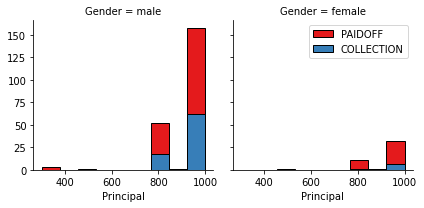

In [7]:
#Lets plot some columns to underestand data better:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

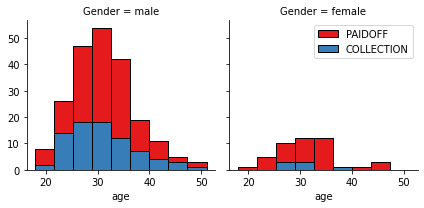

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Pre-processing: Feature selection/extraction

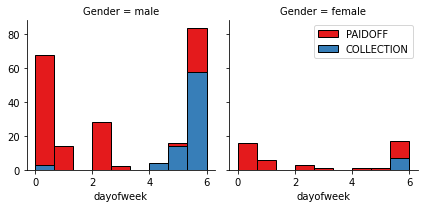

In [9]:
# Lets look at the day of the week people get the loan
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.html
df['dayofweek'] = df['effective_date'].dt.dayofweek 
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [10]:
# We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less than day 4
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Convert Categorical features to numerical values

In [11]:
# Lets look at gender:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [12]:
# Lets convert male to 0 and female to 1:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### One Hot Encoding

In [13]:
# How about education?
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [14]:
#Feature before One Hot Encoding
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [15]:
# Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

In [16]:
# Lets defind feature sets, X:
X_trainset = Feature
X_trainset[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [17]:
#What are our lables?
y_trainset = df['loan_status'].values
y_trainset[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Normalize Data

In [18]:
# Data Standardization give data zero mean and unit variance (technically should be done after train test split )
X_trainset= preprocessing.StandardScaler().fit(X_trainset).transform(X_trainset)
X_trainset[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Classification
Now,use the training set to build an accurate model. Then use the test set to report the accuracy of the model You should use the following algorithm:
* K Nearest Neighbor(KNN)
* Decision Tree
* Support Vector Machine
* Logistic Regression

### K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.

Warning: You should not use the loan_test.csv for finding the best k, however, you can split your train_loan.csv into train and test to find the best k.

In [19]:
# Train Test Split, then use the train/test set of loan_train to find the best k
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_trainset, y_trainset, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [20]:
# Import library
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [21]:
# find the best K for K Nearest Neighbor
Ks = 20
mean_acc_k = np.zeros((Ks-1))
std_acc_k = np.zeros((Ks-1))

for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_k=neigh.predict(X_test)
    mean_acc_k[n-1] = metrics.accuracy_score(y_test, yhat_k)  
    std_acc_k[n-1]=np.std(yhat_k==y_test)/np.sqrt(yhat_k.shape[0])
print( "The best accuracy was with", mean_acc_k.max(), "with k=", mean_acc_k.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


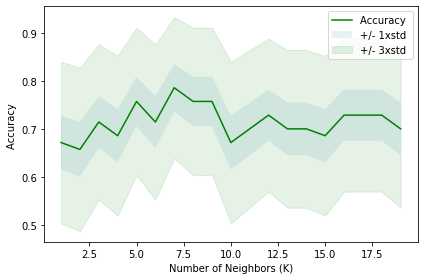

In [22]:
#Plot model accuracy for Different number of Neighbors
plt.plot(range(1,Ks),mean_acc_k,'g')
plt.fill_between(range(1,Ks),mean_acc_k - 1 * std_acc_k,mean_acc_k + 1 * std_acc_k, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc_k - 3 * std_acc_k,mean_acc_k + 3 * std_acc_k, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [23]:
# build model with the best k = 7
k = 7
loanKNN = KNeighborsClassifier(n_neighbors = k)
loanKNN.fit(X_trainset,y_trainset)

KNeighborsClassifier(n_neighbors=7)

### Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
# find the best criterion for the model
criterions = ['gini','entropy']
mean_acc_t = np.zeros(len(criterions))
i = 0
for criterion in criterions:
    findTree = DecisionTreeClassifier(criterion=criterion)
    findTree.fit(X_train,y_train)
    yhat_t = findTree.predict(X_test)
    mean_acc_t[i] = metrics.accuracy_score(y_test, yhat_t) 
    i = i + 1
print( "The best accuracy was with %.2f" % mean_acc_t.max(), "criterion: ", criterions[mean_acc_t.argmax()]) 

The best accuracy was with 0.70 criterion:  gini


In [26]:
#Create an instance of the DecisionTreeClassifier called loanTree.
#Inside of the classifier, specify criterion="entropy" if we want see the information gain of each node.
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#loanTree = DecisionTreeClassifier(criterion="entropy")

# However, criterion is gini gives more accuracy so I will use it in this lab
loanTree = DecisionTreeClassifier(criterion="gini")
#fit the data with the training feature matrix X and training response vector y
loanTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier()

### Support Vector Machine
The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:
* Linear
* Polynomial
* Radial basis function (RBF)
* Sigmoid

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [27]:
from sklearn import svm
# Find the best kernel for the model
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
mean_acc_svm = np.zeros(len(kernels))
i=0
for kernel in kernels:
    #Train Model and Predict 
    svm_test = svm.SVC(kernel=kernel)
    svm_test.fit(X_train,y_train)
    yhat_svm_test = svm_test.predict(X_test)
    mean_acc_svm[i] = metrics.accuracy_score(y_test, yhat_svm_test)
    i = i + 1
print( "The best accuracy was with %.2f" % mean_acc_svm.max(), "kernel: ", kernels[mean_acc_svm.argmax()]) 

The best accuracy was with 0.79 kernel:  linear


In [28]:
# So I will use kernel = linear in this lab
loanSVM = svm.SVC(kernel='linear')
loanSVM.fit(X_trainset, y_trainset) 

SVC(kernel='linear')

### Logistic Regression
Lets build our model using LogisticRegression from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in internet.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization.

In [29]:
from sklearn.linear_model import LogisticRegression
# find the best solver for the model
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
mean_acc_lr = np.zeros(len(solvers))
i = 0
for solver in solvers:
    #train and predict
    test_lr = LogisticRegression(C=0.01, solver=solver)
    test_lr.fit(X_train,y_train)
    yhat_test_lr = test_lr.predict(X_test)
    mean_acc_lr[i] = metrics.accuracy_score(y_test,yhat_test_lr)
    i = i + 1
print(mean_acc_lr)
print( "The best accuracy was with %.2f" % mean_acc_lr.max(), "solver: ", solvers[mean_acc_lr.argmax()])

[0.78571429 0.78571429 0.68571429 0.78571429 0.78571429]
The best accuracy was with 0.79 solver:  newton-cg


In [30]:
# So solver = newton-cg will be used in this lab
loanLR = LogisticRegression(C=0.01, solver='newton-cg')
loanLR.fit(X_trainset,y_trainset)

LogisticRegression(C=0.01, solver='newton-cg')

## Model Evaluation using Test set

In [31]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [32]:
#Loading test ata
import sys
filepath = sys.path[0]
df_test = pd.read_csv(filepath + '/loan_test.csv')
df_test.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [33]:
# data wrangling
#Convert to date time object
df_test['due_date'] = pd.to_datetime(df_test['due_date'])
df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])
# drop unnecessay columns
df_test = df_test.drop('Unnamed: 0', axis = 1)
df_test = df_test.drop('Unnamed: 0.1', axis = 1)
#add day of week and weekend
df_test['dayofweek'] = df_test['effective_date'].dt.dayofweek 
df_test['weekend'] = df_test['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# Lets convert male to 0 and female to 1:
df_test['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df_test.head()
#Feature before One Hot Encoding
df_test[['Principal','terms','age','Gender','education']].head()
Feature = df_test[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df_test['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

In [34]:
# Lets define feature sets, X:
X_testset = Feature
X_testset[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [35]:
#What are our lables?
y_testset = df_test['loan_status'].values
y_testset[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [36]:
# Data Standardization give data zero mean and unit variance (technically should be done after train test split )
X_testset= preprocessing.StandardScaler().fit(X_testset).transform(X_testset)
X_testset[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [37]:
# KNN evaluation
# Using model loanKNN to predict new values with X_testset
yhat_knn = loanKNN.predict(X_testset)

knn_jaccard = jaccard_score(y_testset, yhat_knn, pos_label='PAIDOFF')
knn_f1 = f1_score(y_testset, yhat_knn, average='weighted')

print("KNN Jaccard index: %.2f" % knn_jaccard )
print("KNN F1-score: %.2f" % knn_f1)

KNN Jaccard index: 0.70
KNN F1-score: 0.70


In [38]:
# Decision Tree evaluation
# Using model loanTree to predict new values with X_testset
yhat_tree = loanTree.predict(X_testset)

tree_jaccard = jaccard_score(y_testset, yhat_tree, pos_label='PAIDOFF')
tree_f1 = f1_score(y_testset, yhat_tree, average='weighted')

print("Decision Tree Jaccard index: %.2f" % tree_jaccard )
print("Decision Tree F1-score: %.2f" % tree_f1)

Decision Tree Jaccard index: 0.65
Decision Tree F1-score: 0.69


In [39]:
# Support Vector Machine (SVM) model Evaluation
# Using model loanSVM to predict new values with X_testset
yhat_svm = loanSVM.predict(X_testset)

svm_jaccard = jaccard_score(y_testset, yhat_svm, pos_label='PAIDOFF')
svm_f1 = f1_score(y_testset, yhat_svm, average='weighted')

print("SVM Jaccard index: %.2f" % svm_jaccard)
print("SVM F1-score: %.2f" % svm_f1)

SVM Jaccard index: 0.74
SVM F1-score: 0.63


In [40]:
# Logistic Regression model Evaluation
# Using model loanLR to predict new values with X_testset
yhat_lr = loanLR.predict(X_testset)
yhat_lr_prob = loanLR.predict_proba(X_testset)

lr_jaccard = jaccard_score(y_testset, yhat_lr, pos_label='PAIDOFF')
lr_f1 = f1_score(y_testset, yhat_lr, average='weighted')
lr_logloss = log_loss(y_testset, yhat_lr_prob)

print("Logistic Regression Jaccard index: %.2f" % lr_jaccard )
print("Logistic Regression F1-score: %.2f" % lr_f1 )
print("Logistic Regression log loss: %.2f" % lr_logloss )

Logistic Regression Jaccard index: 0.74
Logistic Regression F1-score: 0.63
Logistic Regression log loss: 0.52


## Report of model's evaluation

In [41]:
ReportCollect = {
    'Algorithm':['K-Nearest Neighbors','Decision Tree','Support Vector Machine','LogisticRegression'],
    'Jaccard':[knn_jaccard,tree_jaccard,svm_jaccard,lr_jaccard],
    'F1-score':[knn_f1,tree_f1,svm_f1,lr_f1],
    'LogLoss':['NA','NA','NA',lr_logloss]
}
Report = pd.DataFrame(ReportCollect)
Report


,Algorithm,Jaccard,F1-score,LogLoss
0,K-Nearest Neighbors,0.700000,0.700199,NA
1,Decision Tree,0.645833,0.688621,NA
2,Support Vector Machine,0.740741,0.630418,NA
3,LogisticRegression,0.740741,0.630418,0.515361
